## MERFISH mouse liver: Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

This notebook contains a prototype implementation of an ovrl.py analysis script for vizgen;s MERF

#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time


#### Parameter definition:

In [3]:
n_sample = 1
n_slice = 1

img_path_wall = f'../../vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = f'../../vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/images/mosaic_DAPI_z4.tif'
coordinate_path = f'../../../../raw_data/vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/detected_transcripts.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:
# SSAM vector field resolution:

# SSAM bandwidth (pixels):
kde_bandwidth=2.0
min_expression=1.5
# # KNN diffusion iterations to move spots to z-axis zero mean:
# z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

perf_=time.perf_counter()

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(f'n_spots: {df.shape[0]}')



n_spots: 419524961


                  x             y             z
count  3.006940e+08  3.006940e+08  3.006940e+08
mean   3.540404e+03  3.690957e+03  2.686015e+00
std    1.947887e+03  2.207887e+03  1.882698e+00
min    1.000000e-04  6.000000e-05  0.000000e+00
25%    1.858254e+03  1.785411e+03  1.000000e+00
50%    3.600892e+03  3.652730e+03  3.000000e+00
75%    5.191113e+03  5.487244e+03  4.000000e+00
max    6.999999e+03  7.999999e+03  6.000000e+00


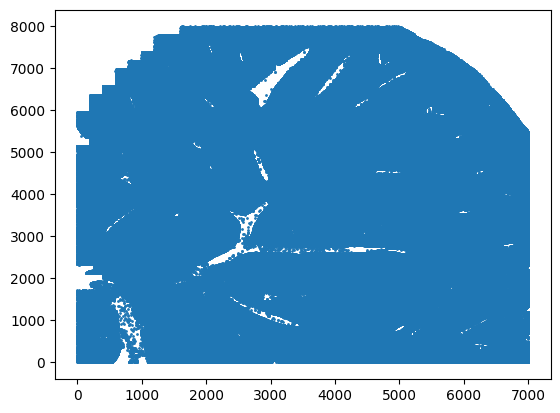

In [6]:
df.columns=['x','y','z','gene']

df = df[~df.gene.str.contains('Blank')]
df.gene = df.gene.astype('category')

raw_df = df.copy()

gene_counts = df.gene.value_counts()
genes = gene_counts.index

x_lims = [2000,9000]
y_lims = [1000,9000]


mins = pd.DataFrame([(0,0)],columns=('x','y'),)

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])
df = df[df_mask]
df.x-=x_lims[0]
df.y-=y_lims[0]

plt.scatter(df.x[::100],df.y[::100],s=1)

coordinate_df = df.copy()
del df

coordinate_df.head()

print(coordinate_df.describe())


In [10]:
from ovrlpy import ovrlp 
import random

random.seed(42)

integrity, signal, visualizer = ovrlp.compute_coherence_map(df=coordinate_df)


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:120: RuntimeWarning: Mean of empty slice
  np.nanmean([elevation_map, np.roll(elevation_map, 1, axis=0)], axis=0) / 4
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:123: RuntimeWarning: Mean of empty slice
  np.nanmean([elevation_map, np.roll(elevation_map, 1, axis=1)], axis=0) / 4
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:126: RuntimeWarning: Mean of empty slice
  np.nanmean([elevation_map, np.roll(elevation_map, -1, axis=0)], axis=0) / 4
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:129: RuntimeWarning: Mean of empty slice
  np.nanmean([elevation_map, np.roll(elevation_map, -1, axis=1)], axis=0) / 4
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:120: RuntimeWarning: Mean of empty slice
  np.nanmean([elevation_map, np.roll(elevation_map, 1, axis=0)], axis=0) / 4
/dh-projects/ag-ishaque/analysis/tiesmeys/s

Analyzing in 3d mode:
determining pseudocells:
Searching within x:(0, 2800), y:(0, 3200), n_molecules:300693961
Using bandwidth: 2.5, min_expression: 0.5, min_pixel_distance: 5.0
found 0 pseudocells


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


KeyboardInterrupt: 

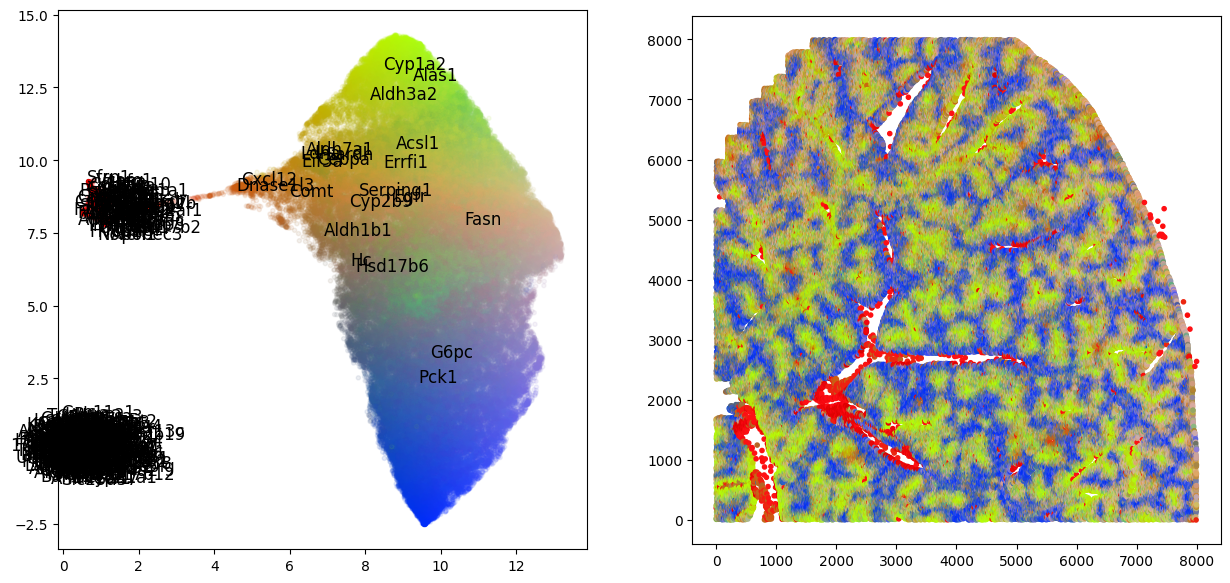

In [30]:
visualizer.plot_fit()

16


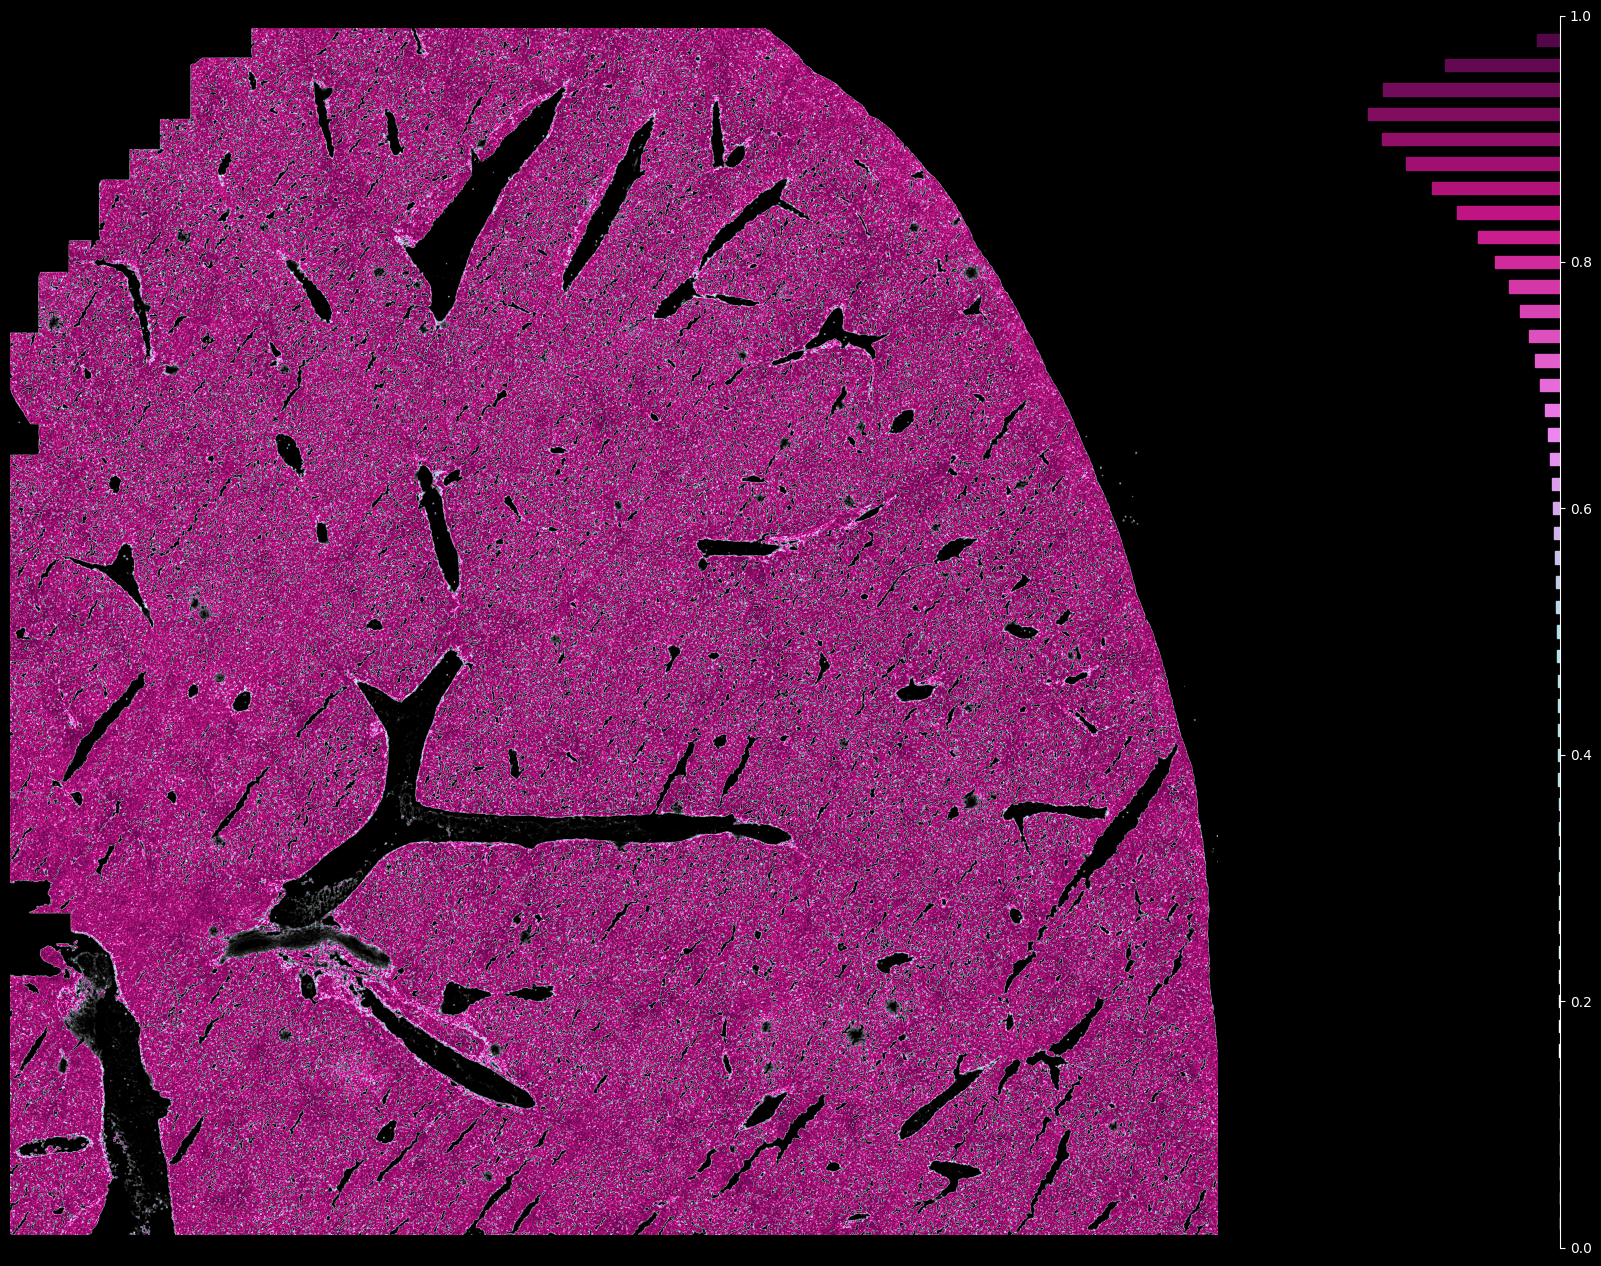

In [31]:
fig, ax = ovrlp.plot_signal_integrity(integrity,signal,signal_threshold=3)


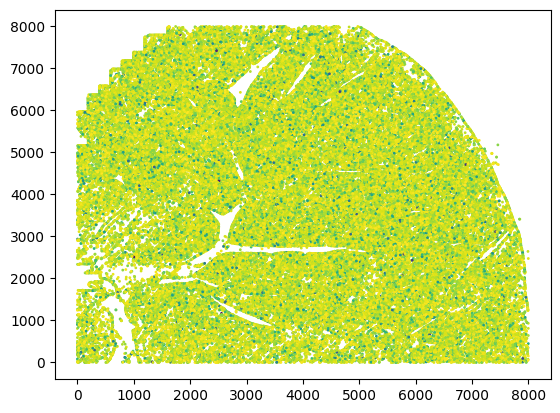

In [32]:
doublet_df = ovrlp.detect_doublets(integrity,signal,signal_cutoff=3,coherence_sigma=3)

plt.scatter(doublet_df.x,doublet_df.y,c=doublet_df.integrity,s=1,cmap='viridis_r')


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/.conda-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


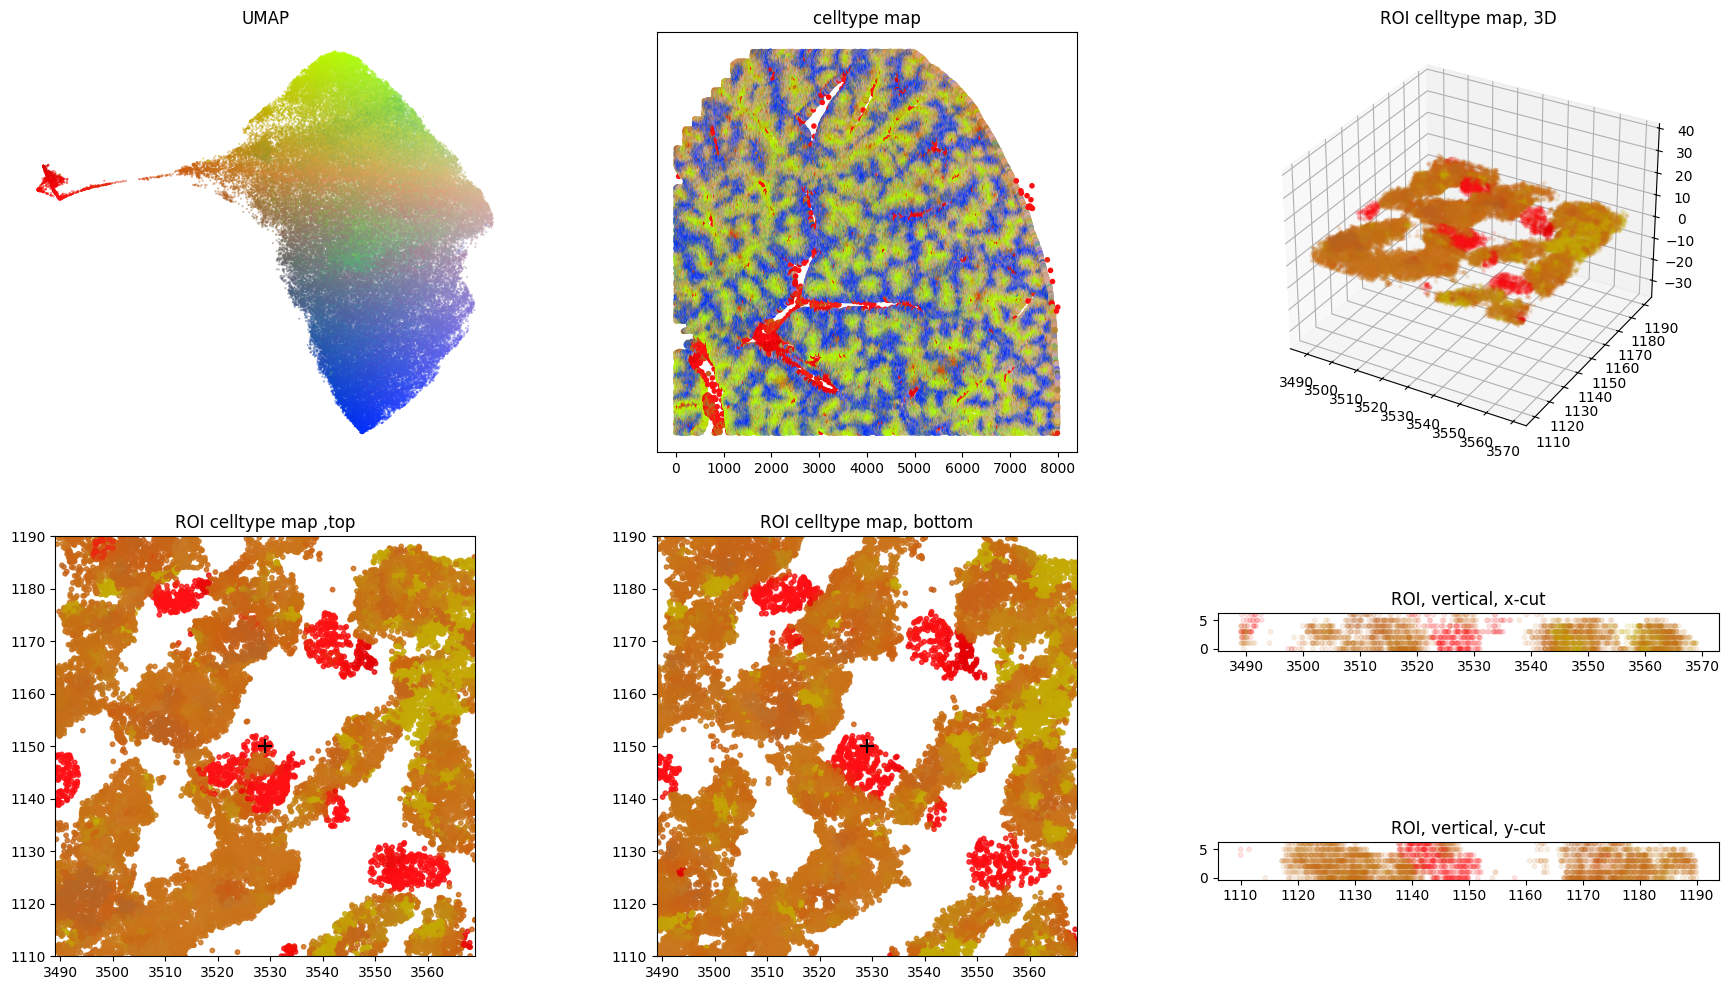

In [34]:
window_size=40
doublet_case = 200

x,y = doublet_df.loc[doublet_case,['x','y']]

subsample = visualizer.subsample_df(x,y,coordinate_df,window_size=window_size)
subsample_embedding, subsample_embedding_color = visualizer.transform(subsample)

visualizer.plot_instance(subsample,subsample[['x','y']].values,subsample_embedding_color,x,y,window_size=window_size,rasterized=True)
